### Improving the model
The first thing we can try is having more data thanks to data augmentation. We will use the following steps:
- Randomly flip the images horizontally
- Randomly rotate the images by 20 degrees
- Randomly zoom the images by 20% (zoom in)
- Randomly zoom the images by 20% (zoom out)

In [21]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras import models

In [22]:
train_ds, test_ds , val_ds= tfds.load('eurosat/rgb', split=['train[:60%]', 'train[60%:80%]', 'train[80%:]'], shuffle_files=False, as_supervised=True)

In [23]:
labels = []
for _, label in train_ds:
    labels.append(label.numpy())
labels = np.unique(labels)

In [24]:
BUFFER_SIZE = 1000
BATCH_SIZE = 32
img_height=64
img_width =64
IMG_SIZE = (img_height, img_width)
def resize_image(images, labels):
    images = tf.image.resize(images, IMG_SIZE)
    return images, labels

In [25]:
train_ds = train_ds.map(resize_image).batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds.map(resize_image).batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.map(resize_image).batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
data_augmentation = models.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

In [27]:
tf.keras.utils.set_random_seed(42)

model_aug = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10)
])

# Compile the model
model_aug.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [28]:
# Make an early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [29]:
history_aug = model_aug.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[early_stopping])

Epoch 1/20


507/507 [==============================] - 42s 73ms/step - loss: 1.3455 - accuracy: 0.4767 - val_loss: 1.4353 - val_accuracy: 0.4743
Epoch 2/20
507/507 [==============================] - 43s 84ms/step - loss: 0.9460 - accuracy: 0.6521 - val_loss: 1.1923 - val_accuracy: 0.5720
Epoch 3/20
507/507 [==============================] - 42s 82ms/step - loss: 0.7408 - accuracy: 0.7302 - val_loss: 0.7303 - val_accuracy: 0.7204
Epoch 4/20
507/507 [==============================] - 39s 76ms/step - loss: 0.6486 - accuracy: 0.7652 - val_loss: 0.7248 - val_accuracy: 0.7281
Epoch 5/20
507/507 [==============================] - 43s 84ms/step - loss: 0.6144 - accuracy: 0.7791 - val_loss: 0.6910 - val_accuracy: 0.7361
Epoch 6/20
507/507 [==============================] - 39s 77ms/step - loss: 0.5687 - accuracy: 0.7956 - val_loss: 0.7354 - val_accuracy: 0.7300
Epoch 7/20
507/507 [==============================] - 37s 73ms/step - loss: 0.5247 - accuracy: 0.8106 - val_loss: 0.5755 - val_accuracy: 0.7904
Epo

In [30]:
test_loss, test_acc = model_aug.evaluate(test_ds)
print('Test accuracy: ', test_acc)

169/169 [==============================] - 2s 9ms/step - loss: 0.4497 - accuracy: 0.8441
Test accuracy:  0.8440740704536438


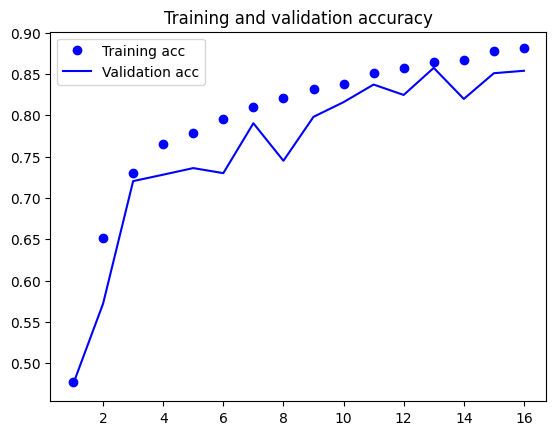

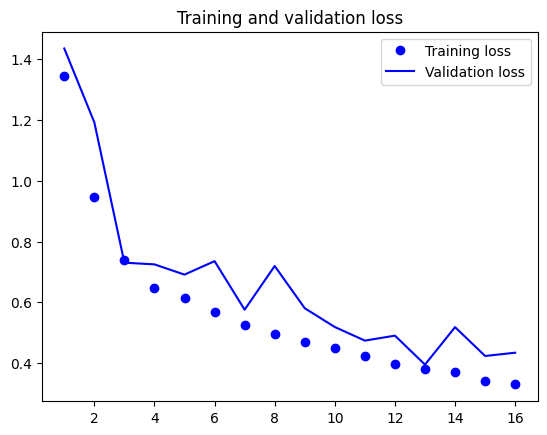

In [31]:
acc = history_aug.history['accuracy']
val_acc = history_aug.history['val_accuracy']
loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

169/169 [==============================] - 1s 8ms/step


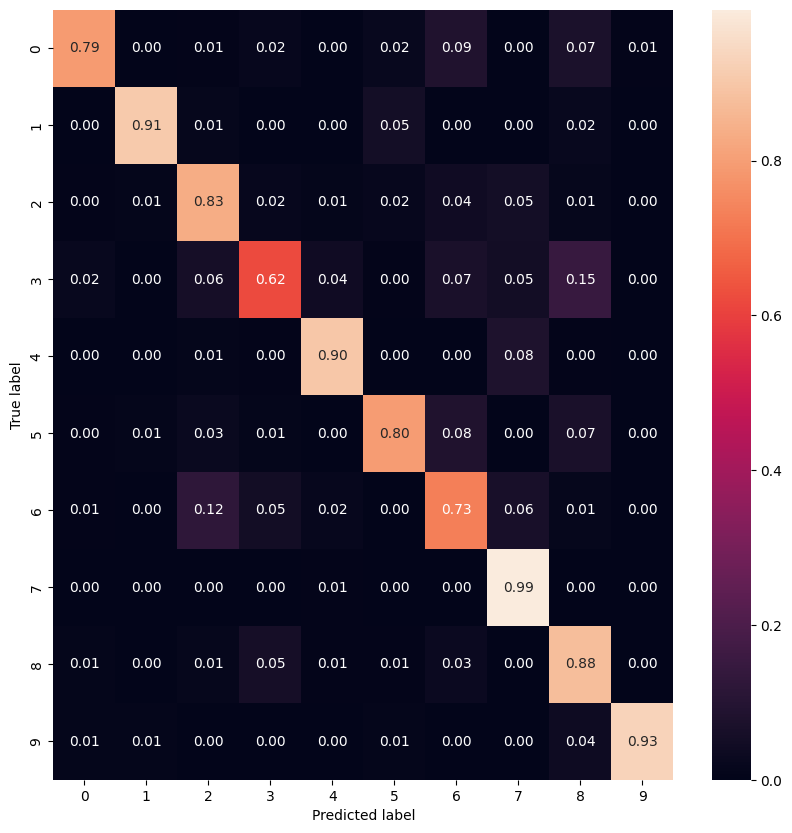

In [32]:
# Show the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model_aug.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = []
for _, label in test_ds:
    y_true.append(label.numpy())
y_true = np.concatenate(y_true)

cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [33]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86       598
           1       0.97      0.91      0.94       593
           2       0.80      0.83      0.82       611
           3       0.78      0.62      0.69       461
           4       0.92      0.90      0.91       504
           5       0.84      0.80      0.82       446
           6       0.71      0.73      0.72       524
           7       0.82      0.99      0.90       599
           8       0.70      0.88      0.78       493
           9       0.99      0.93      0.96       571

    accuracy                           0.84      5400
   macro avg       0.85      0.84      0.84      5400
weighted avg       0.85      0.84      0.84      5400

